In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.shape

(397, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [5]:
#CHANGE THE DATATYPE OF DATE FROM OBJECT TO DATE TIME
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [7]:
#SETTING THE INDEX COLUMN AS INDEX
df.set_index('DATE', inplace = True)

In [8]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


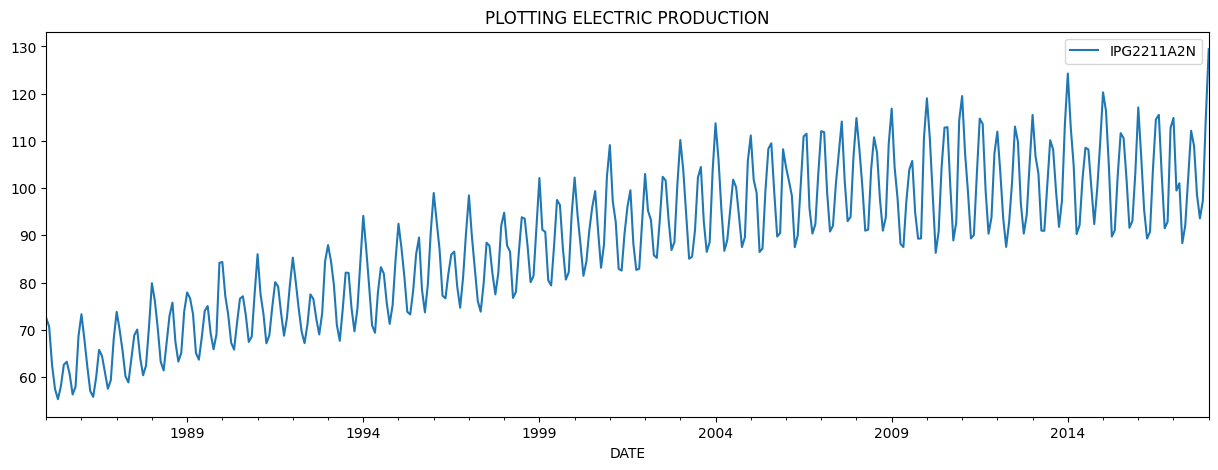

In [9]:
#PLOTTING
df.plot(figsize= (15,5));
plt.title('PLOTTING ELECTRIC PRODUCTION');

**THIS IS AN UPWARD TREND BUT WE WANT A STATIONARY TRNED. SO WE WILL USE DICKEY FULLER TEST**

In [10]:
def adf_test(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'P-Value: {result[1]}')
    if result[1] <= 0.05:
       print('Reject the null hypothesis - Data is stainary')
    else:
       print('Accespt the null hypothesis - Data is not stainary')


In [11]:
adf_test(df['IPG2211A2N'])

ADF Statistics: -2.256990350047235
P-Value: 0.1862146911658712
Accespt the null hypothesis - Data is not stainary


In [12]:
#DIFFERENCING
df['Order_12'] = df['IPG2211A2N'] - df['IPG2211A2N'].shift(12)
#SHIFTED BY 12 BECAUSE THE DATASET FOLLOWS PATTERN OF 12

In [13]:
df.head()

,IPG2211A2N,Order_12
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN


In [14]:
adf_test(df['Order_12'].dropna())

ADF Statistics: -5.673482023381762
P-Value: 8.812644938088861e-07
Reject the null hypothesis - Data is stainary


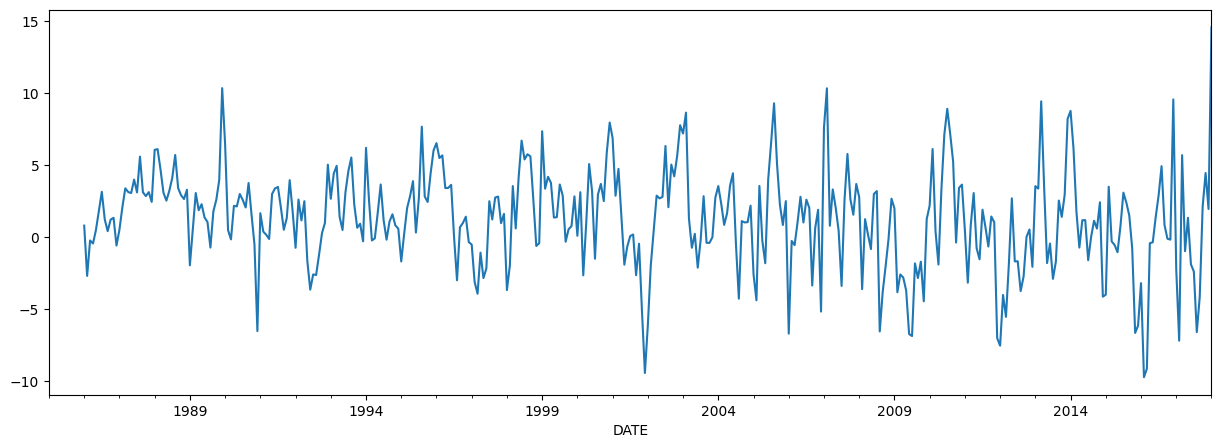

In [15]:
df['Order_12'].plot(figsize= (15,5));

**NOW WE NEED TO CALCULATE P, D AND Q VALUE TO BUILD THE MODEL**

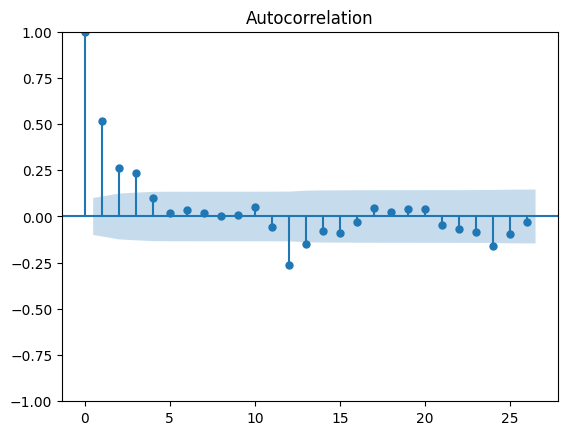

In [16]:
# ACF PLOT
acf = plot_acf(df['Order_12'].dropna())

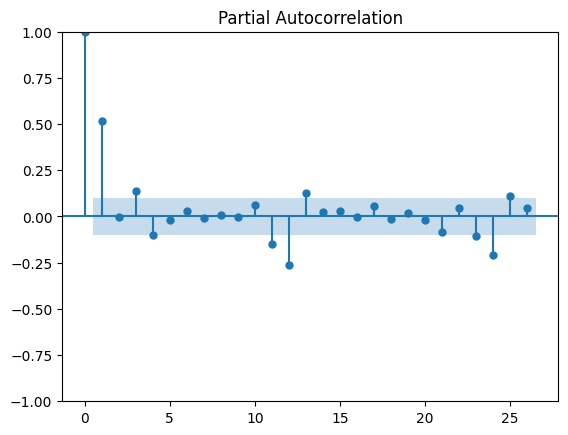

In [17]:
#PACF PLOT
pacf = plot_pacf(df['Order_12'].dropna())


* p = 1
* d = 1
* q = 2/3
/3

In [18]:
train = df[:315]
test = df[315:]

In [19]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
#AUTO ARIMA MODEL FOR BEST PARAMETR
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['IPG2211A2N'], seasonal = True, m = 12)

In [21]:
#PRINT THE BEST PARAMETER - P,Q,D
print(stepwise_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -670.152
Date:                              Sat, 21 Dec 2024   AIC                           1352.305
Time:                                      14:57:49   BIC                           1374.587
Sample:                                  01-01-1985   HQIC                          1361.219
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.069      1.729      0.084      -0.016       0.254
ar.L1          0.92

In [22]:
#FIT THE SARIMAX MODEL USING BEST PARAMETRS
model = SARIMAX(train['IPG2211A2N'],
               order = stepwise_fit.order,
               seasonal_order=stepwise_fit.seasonal_order)

In [23]:
fitted_model= model.fit(disp = False)

In [24]:
print(fitted_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -673.350
Date:                              Sat, 21 Dec 2024   AIC                           1356.700
Time:                                      14:57:51   BIC                           1375.268
Sample:                                  01-01-1985   HQIC                          1364.129
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.003    345.426      0.000       0.992       1.004
ma.L1         -0.41

In [25]:
test.head()

,IPG2211A2N,Order_12
DATE,,
2011-04-01,89.3583,3.0583
2011-05-01,90.0698,-0.7666
2011-06-01,102.8204,-1.5334
2011-07-01,114.7068,1.9002
2011-08-01,113.5958,0.6944


In [26]:
pred = fitted_model.predict(start = test.index[0], end = test.index[-1])

In [27]:
test['Sarimax_pred'] = pred

In [28]:
test.head()

,IPG2211A2N,Order_12,Sarimax_pred
DATE,,,
2011-04-01,89.3583,3.0583,90.159333
2011-05-01,90.0698,-0.7666,92.056593
2011-06-01,102.8204,-1.5334,102.981221
2011-07-01,114.7068,1.9002,110.711943
2011-08-01,113.5958,0.6944,111.491746


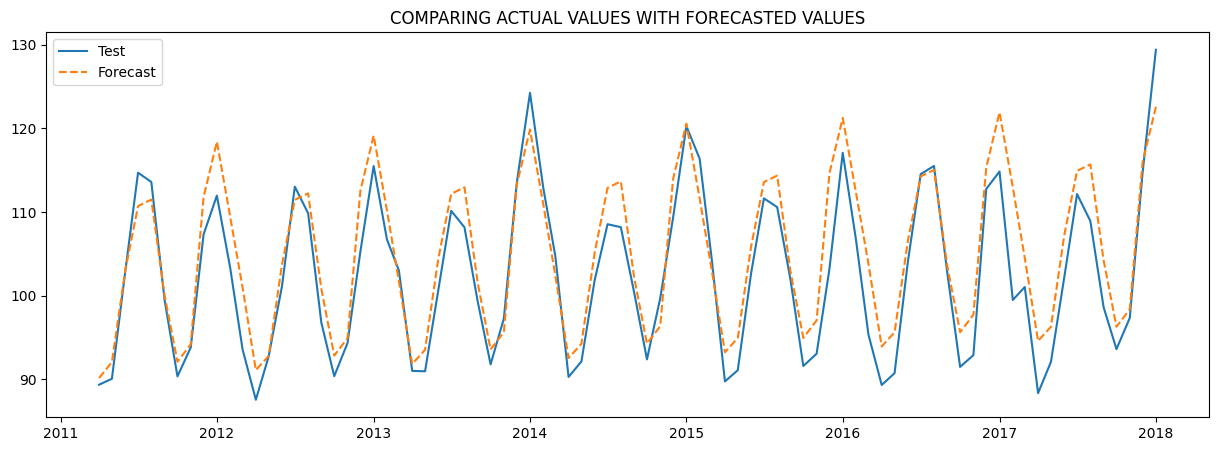

In [29]:
# PLOTTING ACTUAL VS FORECASTED VALUE
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['IPG2211A2N'], label='Test')
plt.plot(test.index, test['Sarimax_pred'], label='Forecast', linestyle='--')
plt.title('COMPARING ACTUAL VALUES WITH FORECASTED VALUES');
plt.legend()